# 0 - Introduction

The work in this notebook is inspired by:
- [Scikit-Learn's `Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
- [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.ca/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291) by **Aurélien Géron**
- [A study on regression applied to the Ames dataset](https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset/notebook)

In [1]:
import gc 
import numpy as np 
from numpy import hstack
from numpy import array
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import os
import sklearn
from scipy import stats
from scipy.stats import norm, skew
import pandas_profiling
%matplotlib inline 

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')   

C:\Users\utente\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\utente\anaconda3\lib\site-packages\numpy\.libs\libopenblas.el2c6ple4zyw3eceviv3oxxgrn2nrfm2.gfortran-win_amd64.dll
C:\Users\utente\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import utils

# 1 - Import Zillow Datasets

Goal is to predict the log-error between their Zestimate (value predicted by Zillow asset evaluation) and the actual sale price, given all the features of a home. 
The log error is defined as
`logerror = log(Zestimate) - log(SalePrice)` 

In [3]:
def load_data(path):
    properties_2016 = pd.read_csv(os.path.join(path, 'properties_2016.csv'),low_memory=False)
    properties_2017 = pd.read_csv(os.path.join(path, 'properties_2017.csv'),low_memory=False)
    train_2016 = pd.read_csv(os.path.join(path, 'train_2016.csv'))
    train_2017 = pd.read_csv(os.path.join(path, 'train_2017.csv'))
    print(properties_2016.shape)
    print(properties_2017.shape)
    print(train_2016.shape)
    print(train_2017.shape)
    
    # Left join will ignore all properties that do not have a logerror (target variable) associated with them
    train_2016 = pd.merge(train_2016, properties_2016, how = 'left', on = 'parcelid')
    train_2017 = pd.merge(train_2017, properties_2017, how = 'left', on = 'parcelid')
    
    all_properties = pd.concat([properties_2016, properties_2017], ignore_index=True)
    print(all_properties.shape)
    all_training = pd.concat([train_2016, train_2017], ignore_index=True)
    return all_properties, all_training

In [52]:
all_properties, df = load_data("zillow-prize-1/")
df.head()

(2985217, 58)
(2985217, 58)
(90275, 3)
(77613, 3)
(5970434, 58)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   parcelid                      167888 non-null  int64  
 1   logerror                      167888 non-null  float64
 2   transactiondate               167888 non-null  object 
 3   airconditioningtypeid         53788 non-null   float64
 4   architecturalstyletypeid      468 non-null     float64
 5   basementsqft                  93 non-null      float64
 6   bathroomcnt                   167854 non-null  float64
 7   bedroomcnt                    167854 non-null  float64
 8   buildingclasstypeid           31 non-null      float64
 9   buildingqualitytypeid         107173 non-null  float64
 10  calculatedbathnbr             166056 non-null  float64
 11  decktypeid                    1272 non-null    float64
 12  finishedfloor1squarefeet      12893 non-null

<Figure size 864x864 with 0 Axes>

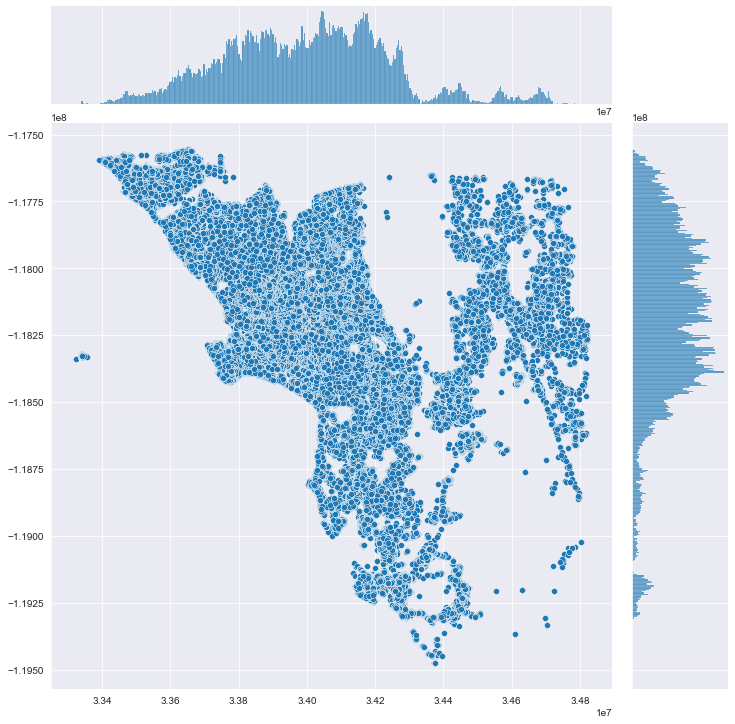

In [54]:
plt.figure(figsize=(12,12))
sns.jointplot(x=all_properties.latitude.values, y=all_properties.longitude.values, height=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)

plt.show()

In [55]:
utils.check_duplicates(df,['parcelid', 'transactiondate'])
df = utils.drop_duplicates(df,['parcelid', 'transactiondate'])
utils.check_duplicates(df,['parcelid', 'transactiondate'])

There are 0 duplicate IDs for 167888 total entries
Dropping all duplicates based on: ['parcelid', 'transactiondate']
There are 0 duplicate IDs for 167888 total entries


In [56]:
#df[["garagecarcnt","garagetotalsqft","fireplacecnt","decktypeid","hashottuborspa","poolcnt","pooltypeid10","pooltypeid2","pooltypeid7","yardbuildingsqft17",
#                 "threequarterbathnbr","taxdelinquencyflag"]].fillna(0,inplace=True)
dropped = ["finishedsquarefeet13", "finishedsquarefeet15", "finishedfloor1squarefeet", "finishedsquarefeet50",
             "storytypeid", "architecturalstyletypeid", "buildingclasstypeid", "typeconstructiontypeid", "finishedsquarefeet6",
             "pooltypeid10", "pooltypeid2", "fireplaceflag", "threequarterbathnbr", "calculatedbathnbr",
             "fullbathcnt", "numberofstories", "censustractandblock", "rawcensustractandblock",
             "finishedsquarefeet12", "taxvaluedollarcnt", "assessmentyear", "roomcnt",
             "regionidneighborhood", "taxdelinquencyyear", "basementsqft",
             "yardbuildingsqft26",
            ]
#df.drop(dropped,axis=1,inplace=True)


In [57]:
# Drop rows containing either 75% or more NaN Values
percent = 50.0 
min_count =  int(((100-percent)/100)*df.shape[1] + 1)
housing = df.dropna(axis=0, thresh=min_count)
housing.shape

(138617, 60)

## Target Variable 

`logerror` is the variable we need to predict.


 mu = 0.01 and sigma = 0.17



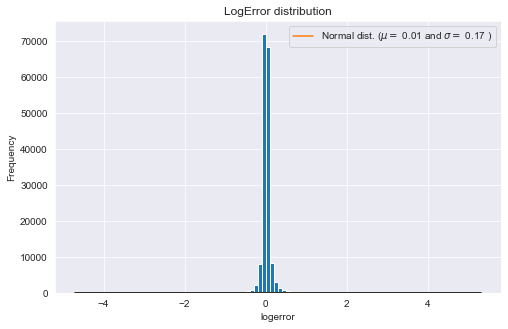

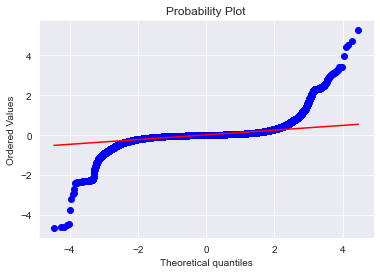

In [58]:
utils.plot_variable(y=df.logerror)

### Dropping Outliers 

Since the data is mostly normally distributed outside of the outliers, we will drop all values that are more than 2.5 standard deviations away from the mean. 

I (others might disagree) don't care about the error itself, but how common (here the freq part) it is. I don't want my model to spend resources trying to learn something that happens very rarely. I think that Zillow Data Scientists are very good, so is useless try to predicting high errors that probably occur for some external factor.

4800 values dropped: 2,85% of original dataset

Highest allowed 0.34531818020294763
Lowest allowed -0.3175055678604645

 mu = 0.01 and sigma = 0.08



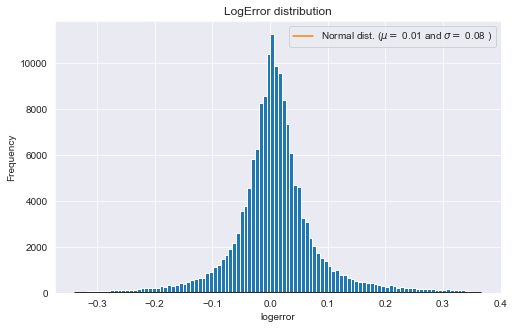

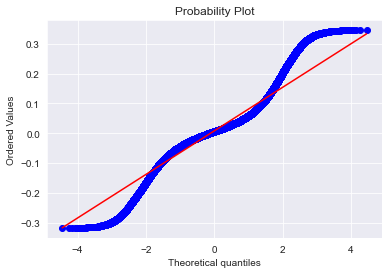

163052

In [59]:
y,df = utils.drop_outliers(df,'logerror',2)
utils.plot_variable(y=df.logerror)
df.logerror.count()

# 2 - Splitting Dataset
Strategy: we could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if we refresh the dataset.

**Since `parcelid` is a unique identifier for each instance in the housing dataset, we can use it to implement the hash strategy outlined above.**


In [60]:
from zlib import crc32
from sklearn.model_selection import train_test_split 

def test_set_check(identifier, test_ratio):
    # hash function
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    
    train_set = data.loc[~in_test_set]
    test_set = data.loc[in_test_set]
    
    X_train = train_set.drop("logerror", axis=1)
    y_train = train_set["logerror"].copy()
    X_test = test_set.drop("logerror", axis=1)
    y_test = test_set["logerror"].copy()
    return X_train, X_test, y_train, y_test

X_other, X_test, y_other, y_test = split_train_test_by_id(df, 0.1, "parcelid")
print(f"Other Dataset Shape: {X_other.shape}; Test Dataset Shape: {X_test.shape}")
print(f"Other Target Shape: {y_other.shape}; Test Target Shape: {y_test.shape}")

Other Dataset Shape: (146781, 59); Test Dataset Shape: (16271, 59)
Other Target Shape: (146781,); Test Target Shape: (16271,)


Next step is to split `X_train, y_train` into Training and Validation Datasets. This is because:
- Test set is kept hidden until the **final** step when the fully tuned machine learning algorithm is ready for deployment. 

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, train_size=0.9, random_state=42)
print(f"Training Dataset Shape: {X_train.shape}")    # 81% of instances are in training 
print(f"Test Dataset Shape: {X_test.shape}")         # 10% of instances are in test 
print(f"Validation Dataset Shape: {X_val.shape}")    # 9% of instances are in validation 

Training Dataset Shape: (132102, 59)
Test Dataset Shape: (16271, 59)
Validation Dataset Shape: (14679, 59)


In [62]:
del all_properties, df; gc.collect()

86594

In [63]:
X_temp = X_train.copy()

In [64]:
results = {}

# 3 - Data Preprocessing Pipelines

In particular these steps refers to Linear Regression pipeline

### Missing Data

In [65]:
all_data_na = (X_train.isnull().sum() / len(X_train)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
buildingclasstypeid,99.985617
finishedsquarefeet13,99.960636
basementsqft,99.943983
storytypeid,99.943983
yardbuildingsqft26,99.902348
fireplaceflag,99.765333
architecturalstyletypeid,99.719913
typeconstructiontypeid,99.687363
finishedsquarefeet6,99.551104
decktypeid,99.246794


### Drop Candidates 

The following variables are dropped. 

Over 90% missing values:
- **finishedsquarefeet13**: Over 99% of the dataset is missing values.
- **finishedsquarefeet15**: Over 96% of the dataset is missing values.
- **finishedfloor1squarefeet**: Over 92% of the dataset is missing values.
- **finishedsquarefeet50**: Over 92% of the dataset is missing values.
- **storytypeid**: Over 99% of the dataset is missing values.
- **buildingclasstypeid**: Over 99.8% of the dataset is missing values. 
- **architecturalstyletypeid**: Over 99% of the dataset is missing values.
- **typeconstructiontypeid**: Over 99% of the dataset is missing values.
- **finishedsquarefeet6**: Over 99% of the dataset is missing values. 
- **basementsqft, yardbuildingsqft26**:  Over 96% of the dataset is missing values.
- **taxdelinquencyyear**: Over 97% of the dataset is missing values.
<br>

- **numberofstories**: With over 77% of the missing values and no one value dominating the variable distribution, it is impractical to impute. 



 mu = 1.44 and sigma = 0.54



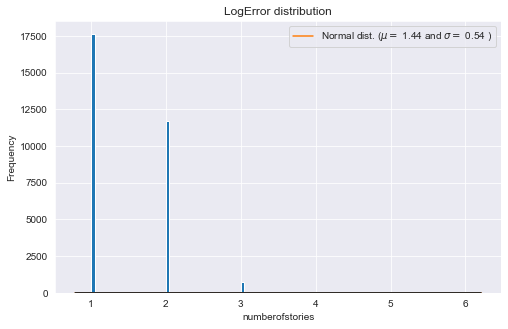

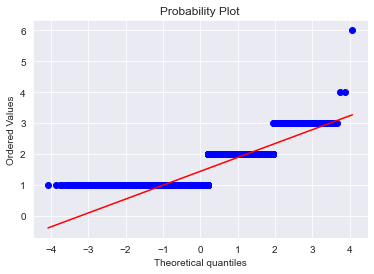

In [66]:
utils.plot_variable(X_train.numberofstories.dropna())

- **assessmentyear**: 2015 for 2016's properties and 2016 for 2017's properties. So, for now we drop it.

- **parcelid, transactiondate**: These variables are not available when we trying to predict target variable `logerror` 

- **rawcensustractandblock**: A wikipedia search revealed: Census tracts represent the smallest territorial unit for which population data are available in many countries. In the United States, census tracts are subdivided into block groups and census blocks. In the U.S., census tracts are “designed to be relatively homogeneous units with respect to population characteristics, economic status, and living conditions” and “average about 4,000 inhabitants”. Impractical to impute. Probably we want to do splitting like described above, but before doing this, it is better to do further research
- **censustractandblock**: Same as above.

#### Duplicate Features 

- **pooltypeid10, hashottuborspa**: Duplicate information is present in `pooltypeid2` feature.
- **pooltypeid7**: Data description states 'Pool without Hot Tub', duplicate information is present in `pooltypeid2` feature which is boolean for 'Pool with Spa/Hot Tub'
- **fireplaceflag**: Duplicate information is present in `fireplacecnt` feature with `fireplaceflag` having a higher missing ratio. 
- **calculatedbathnbr, threequarterbathnbr, fullbathcnt**: Duplicate information is present in `bathroomcnt` which has a lower missing ratio
- **finishedsquarefeet12**: Duplicate information in `calculatedfinishedsquarefeet`.
- **taxvaluedollarcnt**: Duplicate information from the sum of `structuretaxvaluedollarcnt` and `landtaxvaluedollarcnt`
- **propertyzoningdesc, propertycountylandusecode**: `propertylandusetypeid` already provides similar information. In addition, this variable has over 2300 unique values - drastically increasing dataset cardinality. 
- **regionidneighborhood, regionidzip, regionidcity**: With over 60% of the dataset missing values and 500+ unique values, there are better region based features such as `regionidcounty, latitude, longitude` to obtain this information


- **roomcnt**: Shows inconsistent data with majority of properties having 0 rooms in the principal residence. We will use bedroom and bathroom count.

<AxesSubplot:>

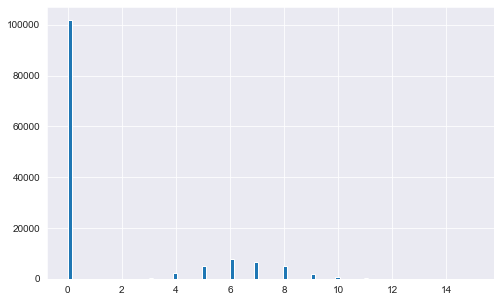

In [67]:
X_train.roomcnt.hist(bins=100, figsize=(8,5))

## Dropping Features Pipeline

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin

lin_reg_drop_vars = ["finishedsquarefeet13", "finishedsquarefeet15", "finishedfloor1squarefeet", "finishedsquarefeet50",
             "storytypeid", "architecturalstyletypeid", "buildingclasstypeid", "typeconstructiontypeid", "finishedsquarefeet6",
             "pooltypeid10", "hashottuborspa", "fireplaceflag", "threequarterbathnbr", "calculatedbathnbr",
             "fullbathcnt", "numberofstories", "censustractandblock", "rawcensustractandblock",
             "finishedsquarefeet12", "taxvaluedollarcnt", "taxamount", "assessmentyear", "roomcnt",
             "propertyzoningdesc", "regionidneighborhood", "regionidzip", "taxdelinquencyyear",
             "propertycountylandusecode", "regionidcity", "parcelid", "basementsqft", "yardbuildingsqft26", "transactiondate"
            ]

feat_dropper = utils.FeatureDropper(features_to_drop=lin_reg_drop_vars)
X_temp = feat_dropper.fit_transform(X_temp)

## Data Imputation Pipeline

There are two main types of data imputation:
1) **Univariate Imputation**: Impute values in a feature using only non-missing values in that feature only. Examples include calculating the mean/median/mode of a specific variable such as `lot_size` from all non-missing values and imputing the calculated value for missing `lot_size` rows. 

2) **Multivariate Imputation**: Multivariate imputation algorithms use the entire set of available feature dimensions to estimate the missing values (e.g. impute.IterativeImputer). Basically, the purpose of multivariate imputation is to use other features (columns) in the dataset to predict the missing value(s) in the current feature.


## Univariate Imputation

### 0/None Imputation Features
Based on the data descriptions of the following features, missing values most likely indicate the property missing the specific feature (eg: no basement, no shed, no pool, etc.). Thus, the imputed values in either `0`, `None`, etc. depending on the variable type. 

**0 Imputation**

- **yardbuildingsqft17**: Data description says 'Patio in yard'. Missing values are likely zero for having no patio in yard.
- **fireplacecnt**: Missing values must indicate no fireplace present in the unit, thus imputing `0` for all missing values. 
- **poolcnt**: All values are `1` in data indicating one pool is present, missing values must be `0` indicating otherwise. 
- **poolsizesum**: All missing values indicate no pool on property, thus impute `0` for sqaure footage of all pools. 
- **pooltypeid2**: All values are `1` in data indicating a pool with spa/hot tub is present, missing values must be `0` indicating otherwise. 
- **pooltypeid7**: All values are `1` in data indicating a pool without hot tub is present, missing values must be `0` indicating otherwise. 
- **hashottuborspa**: All values are `1` in data indicating a spa/hot tub is present, missing values must be `0` indicating no hot tub/spa. 
- **decktypeid**: Same value in data indicating a deck is present, missing values must be `0` indicating no deck. 
- **taxdelinquencyflag**: All values are `Y` in data for properties that are tax delinquent implying all missing values must be `N` or `0` for easier handling. 
- **garagecarcnt**: No properties have `0` as the garage car count, indicating the missing values are all properties without a garage. 
- **garagetotalsqft**: All properties with missing `garagecarcnt` are also missing the square feet, indicating the properties do not have a garage. 

### Mode Imputation Features

The following features are imputed with the most frequent value (mode) due to the majority of the dataset having that specific value. 
- **airconditioningtypeid**: Majority of the properties have a Central air conditioning type. 
- **heatingorsystemtypeid**: Majority of the properties have a Central heating system. 
- **unitcnt**: Majority of the property are built into 1 unit.
- **fips, propertylandusetypeid, regionidcounty**: With only 0.4% of the dataset missing values, imputing the mode is acceptable. 
- **yearbuilt**: Since missing rows is extremely low, mode suffices

### Median Imputation Features

The following features are imputing with the 50th percentile value (median) to best represent the numerical distributions represented by each features. 
- **buildingqualitytypeid**: Overall condition of the condition from best (lowest) to worst (highest). Thus, imputing the median for missing values. 
- **lotsizesquarefeet**: Continuous numerical variable for area of the lot
- **bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet**
- **structuretaxvaluedollarcnt, landtaxvaluedollarcnt, latitude, longitude**

In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [70]:
impute_0_vars = ["yardbuildingsqft17", "fireplacecnt", "poolcnt", "garagecarcnt", "garagetotalsqft",
                 "pooltypeid2", "poolsizesum", "decktypeid", "taxdelinquencyflag","pooltypeid7"]

impute_mode_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "unitcnt", "fips",
                    "propertylandusetypeid", "regionidcounty", "yearbuilt"] 

impute_median_vars = ["buildingqualitytypeid", "lotsizesquarefeet", "bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet",
                      "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt", "latitude", "longitude"]

univariate_impute_pipe = utils.ColumnTransformer([
        ("impute_0", SimpleImputer(strategy="constant", fill_value=0), impute_0_vars),
        ("impute_mode", SimpleImputer(strategy="most_frequent"), impute_mode_vars),
        ("impute_median", SimpleImputer(strategy="median"), impute_median_vars),
    ],
    remainder='passthrough'
)

X_temp = univariate_impute_pipe.fit_transform(X_temp)

## Column Names Appender Pipeline

The output of the imputation pipeline is not a Pandas DataFrame but a NumPy Array. The following pipeline takes as an input the imputation pipeline and creates a DataFrame from the Numpy Array input. 

In [71]:
column_appender = utils.ColumnNamesAppender(univariate_impute_pipe, orig_columns=X_train.columns, num_transformers=3)
X_temp = column_appender.fit_transform(X_temp)

## Convert Variables Types Pipeline

Many categorical and boolean variables are currently encoded as floats, so we convert them.

In [72]:
convert_to_int = ["yearbuilt"] 
convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag",] 
convert_to_float= ["bathroomcnt", "bedroomcnt", "buildingqualitytypeid", "calculatedfinishedsquarefeet",
                  "fireplacecnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet", "poolcnt",
                  "poolsizesum", "unitcnt", "yardbuildingsqft17", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]
    
# # Code to test pipeline
feature_type_changer = utils.ConvertFeatureType(convert_to_int=convert_to_int, convert_to_string=convert_to_string, convert_to_float=convert_to_float)
X_temp = feature_type_changer.fit_transform(X_temp)

## Year Feature Creation Pipeline

 `1989` is converted into `present_year(2021) - 1989 = 32` 

In [73]:
from datetime import date
date_features = {"yearbuilt": "house_age"}

year_feat_creator = utils.CreateYearFeatures(date_features=date_features)
X_temp = year_feat_creator.fit_transform(X_temp)

## One-Hot Encoding Categorical Variables + Standardizing Numerical Variables 
The following custom transformer uses `ColumnTransformer` to perform One-Hot Encoding on Categorical Features and Robust Scaler on Numerical Features.

In [74]:
feature_encoder_scaler = utils.FeatureEncoderAndScaler()
X_temp = feature_encoder_scaler.fit_transform(X_temp)

## Create Polynomial Features Pipeline

The three new polynomial features are: 
- `feature^2`
- `feature^3`
- `sqrt(feature)` 

This transformation is useful for models such as linear regression compared to more complex models such as Random Forest, GBMs that can detect non-linear patters within the data without such feature engineering.

In [75]:
corr_df = X_temp.copy()
corr_df["logerror"] = y_train.values
corr = corr_df.corr()
most_corr_feat = corr.logerror.abs().sort_values(ascending=False)[1:9].index
most_corr_feat

Index(['num_scaler__calculatedfinishedsquarefeet', 'num_scaler__bathroomcnt',
       'num_scaler__bedroomcnt', 'num_scaler__structuretaxvaluedollarcnt',
       'num_scaler__house_age', 'num_scaler__garagetotalsqft',
       'num_scaler__landtaxvaluedollarcnt', 'num_scaler__garagecarcnt'],
      dtype='object')

In [76]:
poly_feat_creator = utils.CreatePolynomialFeatures(most_corr_feat)
X_temp = poly_feat_creator.fit_transform(X_temp)

## Skewed Features Pipeline
Next transformation is applied to numerical features that are highly skewed (all variables with skewness above the threshold value of 0.75). We will be performing the **Box Cox Transformation** using scipy function `boxcox1p`.  

In [77]:
numeric_feats = X_temp.dtypes[X_temp.dtypes == 'float'].index
skewed_feats = X_temp[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print(skewed_feats[:20])

skew_transformer = utils.BoxCoxSkewedFeatures()
X_temp = skew_transformer.transform(X_temp)

num_scaler__structuretaxvaluedollarcnt-s3      188.246998
num_scaler__unitcnt                            186.776719
num_scaler__landtaxvaluedollarcnt-s3           181.553795
num_scaler__bathroomcnt-s3                     151.889413
num_scaler__calculatedfinishedsquarefeet-s3    116.428447
num_scaler__garagetotalsqft-s3                 106.881884
num_scaler__landtaxvaluedollarcnt-s2           103.260718
num_scaler__structuretaxvaluedollarcnt-s2       93.976187
num_scaler__garagecarcnt-s3                     89.126351
num_scaler__calculatedfinishedsquarefeet-s2     38.796511
num_scaler__bedroomcnt-s3                       36.400945
num_scaler__garagetotalsqft-s2                  28.797628
num_scaler__lotsizesquarefeet                   26.200211
num_scaler__bathroomcnt-s2                      18.750082
num_scaler__garagecarcnt-s2                     16.122097
num_scaler__yardbuildingsqft17                  12.331821
num_scaler__bedroomcnt-s2                       12.258034
num_scaler__la

# 4 - Linear Regression Models 

Both plain Linear Regression and Regularized Linear Regression algorithms will be tested.

In [78]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor

In [79]:
X_prepared = X_train.copy()
X_prepared_val = X_val.copy()

In [80]:
# Feature Dropper Pipeline
lin_reg_drop_vars = ["finishedsquarefeet13", "finishedsquarefeet15", "finishedfloor1squarefeet", "finishedsquarefeet50",
             "storytypeid", "architecturalstyletypeid", "buildingclasstypeid", "typeconstructiontypeid", "finishedsquarefeet6",
             "pooltypeid10", "hashottuborspa", "fireplaceflag", "threequarterbathnbr", "calculatedbathnbr",
             "fullbathcnt", "numberofstories", "censustractandblock", "rawcensustractandblock",
             "finishedsquarefeet12", "taxvaluedollarcnt", "taxamount", "assessmentyear", "roomcnt",
             "propertyzoningdesc", "regionidneighborhood", "regionidzip", "taxdelinquencyyear",
             "propertycountylandusecode", "regionidcity", "parcelid", "basementsqft", "yardbuildingsqft26", "transactiondate"
            ]
feature_dropper = utils.FeatureDropper(features_to_drop=lin_reg_drop_vars)

date_features = {"yearbuilt": "house_age"}
# Convert Date Features Pipeline
year_feat_creator = utils.CreateYearFeatures(date_features=date_features)

# Feature Encoding and Scaling Pipeline
feature_encoder_scaler = utils.FeatureEncoderAndScaler()

# Transform Skewed Numerical Features Pipeline
skew_transformer = utils.BoxCoxSkewedFeatures()

# Two versions below: Univariate Imputation and Multivariate Imputation:
# True for univariate imputation, false for multivariate imputation
########################################### 
univariate = True 
if univariate:
    # 1) Univariate Imputation Pipeline
    
    impute_0_vars = ["yardbuildingsqft17", "fireplacecnt", "poolcnt", "garagecarcnt", "garagetotalsqft",
                 "pooltypeid2", "poolsizesum", "decktypeid", "taxdelinquencyflag","pooltypeid7"]

    impute_mode_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "unitcnt", "fips",
                        "propertylandusetypeid", "regionidcounty", "yearbuilt"] 

    impute_median_vars = ["buildingqualitytypeid", "lotsizesquarefeet", "bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet",
                          "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt", "latitude", "longitude"]

    convert_to_int = ["yearbuilt"] 
    convert_to_float= ["bathroomcnt", "bedroomcnt", "buildingqualitytypeid", "calculatedfinishedsquarefeet",
                      "fireplacecnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet", "poolcnt",
                      "poolsizesum", "unitcnt", "yardbuildingsqft17", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]

    convert_to_bool = ["pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
    convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty"]
    univariate_impute_pipe = utils.ColumnTransformer([
            ("impute_0", SimpleImputer(strategy="constant", fill_value=0), impute_0_vars),
            ("impute_mode", SimpleImputer(strategy="most_frequent"), impute_mode_vars),
            ("impute_median", SimpleImputer(strategy="median"), impute_median_vars),
        ],
        remainder='passthrough'
    )
    col_name_appender = utils.ColumnNamesAppender(univariate_impute_pipe, X_train.columns, num_transformers=3)
    feature_type_changer = utils.ConvertFeatureType(convert_to_int=convert_to_int, convert_to_string=convert_to_string, 
                                              convert_to_float=convert_to_float, convert_to_bool=convert_to_bool)
    
    poly_feat_creator = utils.CreatePolynomialFeatures(most_corr_feat)

else:
    #2) Multivariate Version
    cat_impute_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
    numeric_impute_vars = ["bathroomcnt", "bedroomcnt", "buildingqualitytypeid", "calculatedfinishedsquarefeet",
                      "fireplacecnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet", "poolcnt",
                      "poolsizesum", "unitcnt", "yardbuildingsqft17", "yearbuilt", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]

    convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"]
    multivariate_impute_pipe = utils.ColumnTransformer([
            ("impute_cats", SimpleImputer(strategy="constant", fill_value='missing'), cat_impute_vars),
            ("impute_num", IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, max_depth=30, min_samples_leaf=32), random_state=0, max_iter=1), numeric_impute_vars),
        ],
        remainder='passthrough'
    )
    col_name_appender = utils.ColumnNamesAppender(multivariate_impute_pipe, X_train.columns, num_transformers=3)
    feature_type_changer = utils.ConvertFeatureType(convert_to_int=convert_to_int, convert_to_string=convert_to_string, convert_to_float=convert_to_float)
    most_corr_feat = list(map(lambda x: x.replace('num_scaler__',''), most_corr_feat))     # Clean up feature names by removing `num_scaler__`
    poly_feat_creator = utils.CreatePolynomialFeatures(most_corr_feat)


In [81]:
if univariate:
    imputation = univariate_impute_pipe
else:
    imputation = multivariate_impute_pipe
lin_reg_preprocessor = Pipeline([
        ('feature_dropper', feature_dropper),
        ('imputation', imputation),
        ('col_name_appender', col_name_appender),
        ('feature_type_changer', feature_type_changer),
        ('year_feat_creator', year_feat_creator),
        ('feature_encoder_scaler', feature_encoder_scaler),
        ('skew_transformer', skew_transformer),
    ],verbose=True)

data_prep_pipe = lin_reg_preprocessor.fit(X_prepared)
X_prepared = lin_reg_preprocessor.transform(X_prepared)
X_prepared_val = lin_reg_preprocessor.transform(X_prepared_val)

[Pipeline] ... (step 1 of 7) Processing feature_dropper, total=   0.0s
[Pipeline] ........ (step 2 of 7) Processing imputation, total=   0.5s
[Pipeline] . (step 3 of 7) Processing col_name_appender, total=   0.0s
[Pipeline]  (step 4 of 7) Processing feature_type_changer, total=   0.6s
[Pipeline] . (step 5 of 7) Processing year_feat_creator, total=   0.1s
[Pipeline]  (step 6 of 7) Processing feature_encoder_scaler, total=   6.4s
[Pipeline] .. (step 7 of 7) Processing skew_transformer, total=   0.0s


In [82]:
from sklearn import set_config
set_config(display='diagram')
lin_reg_preprocessor

Pipeline(steps=[('feature_dropper',
                 FeatureDropper(features_to_drop=['finishedsquarefeet13',
                                                  'finishedsquarefeet15',
                                                  'finishedfloor1squarefeet',
                                                  'finishedsquarefeet50',
                                                  'storytypeid',
                                                  'architecturalstyletypeid',
                                                  'buildingclasstypeid',
                                                  'typeconstructiontypeid',
                                                  'finishedsquarefeet6',
                                                  'pooltypeid10',
                                                  'hashottuborspa',
                                                  'fireplaceflag',
                                                  'threequarterbathnbr',
                                                  'calcu...
                                         features_to_scale=Index(['yardbuildingsqft17', 'fireplacecnt', 'poolcnt', 'garagecarcnt',
       'garagetotalsqft', 'poolsizesum', 'unitcnt', 'buildingqualitytypeid',
       'lotsizesquarefeet', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'latitude', 'longitude', 'house_age'],
      dtype='object'))),
                ('skew_transformer', BoxCoxSkewedFeatures())],
         verbose=True)

In [83]:
X_lin = X_prepared.copy()
X_lin_val = X_prepared_val.copy()

## Model Evaluation 

### Baseline Metrics 

It is important to set a baseline for the model's performance to compare different algorithms. 

For this regression problem, we will use the models' **MAE (Mean Absolute Error)** and **RMSE (Root Mean Squared Error)**.

We will observe the RMSE as another evaluation metric which punishes more for outliers than MAE. 

In [84]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [85]:
print(f"MAE Baseline: {y_train.mad()}")
print(f"RMSE Baseline: {y_train.std()}")

MAE Baseline: 0.050452884735592965
RMSE Baseline: 0.07624165410510253


### MAE Evaluation 

To evaluate and short list the most promising models, we will use the models' **MAE** in two different ways: 

1) **MAE on Validation Set**
2) **K-Fold Cross-Validation**



In [86]:
def get_eval_metrics(models, X, y_true): 
    """
    Calculates MAE (Mean Absoulate Error) and RMSE (Root Mean Squared Error) on the data set for input models. 
    `models`: list of fit models 
    """
    for model in models: 
        y_pred= model.predict(X)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true, y_pred)
        print(f"Model: {model}")
        print(f"MAE: {mae}, RMSE: {rmse}")
        return mae

def display_scores(model, scores):
    print("-"*50)
    print("Model:", model)
    print("\nScores:", scores)
    print("\nMean:", scores.mean())
    print("\nStandard deviation:", scores.std())
    
def get_cross_val_scores(models, X, y, cv=10, fit_params=None):
    """
    Performs k-fold cross validation and calculates MAE for each fold for all input models. 
    `models`: list of fit models 
    """    
    maes = []
    for model in models: 
        mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=cv, fit_params=fit_params)
        display_scores(model, mae) 
        maes.append(mae)
    return maes

In [87]:
%%time
lin_reg = LinearRegression()
lin_reg.fit(X_lin[:100], y_train[:100])

utils.get_eval_metrics([lin_reg], X_lin_val, y_val)
utils.get_cross_val_scores([lin_reg], X_lin, y_train, cv=5)

Model: LinearRegression()
MAE: 0.06382852104653065, RMSE: 0.08914220933427222
--------------------------------------------------
Model: LinearRegression()

Scores: [5.02387980e-02 7.77971364e+05 5.67568615e+05 4.99331347e-02
 5.00348786e-02]

Mean: 269108.02576582454

Standard deviation: 336237.39467363775
CPU times: total: 8.59 s
Wall time: 5.49 s


[array([5.02387980e-02, 7.77971364e+05, 5.67568615e+05, 4.99331347e-02,
        5.00348786e-02])]

In [88]:
result = utils.get_eval_metrics([lin_reg], X_lin_val, y_val)
results['lin_reg'] = result

Model: LinearRegression()
MAE: 0.06382852104653065, RMSE: 0.08914220933427222


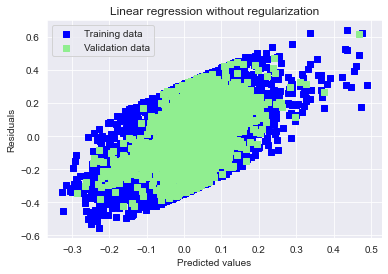

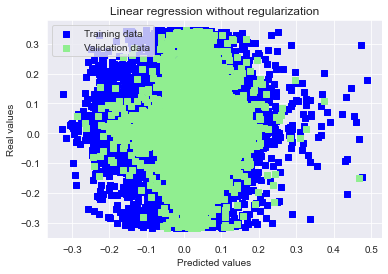

Linear Regression picked 49 features and eliminated the other 10 features


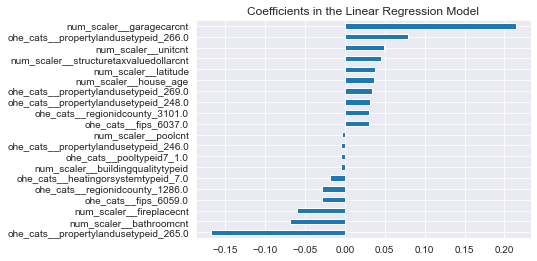

In [89]:
y_train_prediction = lin_reg.predict(X_lin)
y_val_prediction = lin_reg.predict(X_lin_val)

# Plot residuals
plt.scatter(y_train_prediction, y_train_prediction - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_prediction, y_val_prediction - y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression without regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

# Plot predictions
plt.scatter(y_train_prediction, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_val_prediction, y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression without regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.show()

# Plot important coefficients
coefs = pd.Series(lin_reg.coef_, index = X_lin.columns)
print("Linear Regression picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Linear Regression Model")
plt.show()

### Learning Curves 

To detect where the model is under or overfitting, we can look at the *learning curves*.

In [90]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    """
    Train the input model on different sized subsets and test on validation set. 
    Output a plot of training and validation error for the different sized subsets. 
    """
    train_errors, val_errors = [], []
    num_instances = np.linspace(1, len(X_train), num=15).astype(int)
    
    for m in num_instances:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_absolute_error(y_train[:m], y_train_predict))
        val_errors.append(mean_absolute_error(y_val, y_val_predict))
    plt.plot(num_instances, train_errors, "r-+", linewidth=2, label="train")
    plt.plot(num_instances, val_errors, "b-", linewidth=3, label="val")
    plt.legend(loc='best')
    plt.title(model)
    return plt

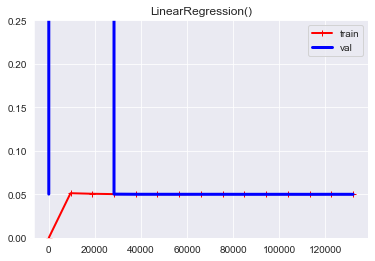

In [91]:
lin_reg = LinearRegression()
plt = plot_learning_curves(lin_reg, X_prepared, y_train, X_prepared_val, y_val)
plt.ylim(0, 0.25) 
plt.show()

### Learning Curve Conclusion for Linear Regression 

- The model is not overfitting as the MAE error observed for both the validation and training sets is extremely close (errors would be different between `train` and `val` datasets if the model were overfitting with the `train` dataset, thus showing lower MAE values.  

## 1b) Ridge and Lasso Regression 

Since the Ridge and Lasso models' performance is highly affected by the chosen `alpha` value, we need to tune its value to find the optimal `alpha` for the given problem. 

**NOTE**: **In this case, any of the Regularized Linear Models will NOT perform any better than the Simple Linear Regression. Regularized models help reduce overfitting and we have already established that our current Linear Model is underfitting.**

In [92]:
%%time

# Set of alpha values to test
alphas = np.logspace(0,2,20)
print(f"Testing with alphas={alphas}")


# Tune Ridge Regression
ridgecv = RidgeCV(alphas=alphas)
ridgecv.fit(X_prepared, y_train)
print(f"Best Ridge Alpha: {ridgecv.alpha_}")

Testing with alphas=[  1.           1.27427499   1.62377674   2.06913808   2.6366509
   3.35981829   4.2813324    5.45559478   6.95192796   8.8586679
  11.28837892  14.38449888  18.32980711  23.35721469  29.76351442
  37.92690191  48.32930239  61.58482111  78.47599704 100.        ]
Best Ridge Alpha: 37.926901907322495
CPU times: total: 4.47 s
Wall time: 2.36 s


In [93]:
%%time

# Set of alpha values to test
alphas = np.logspace(1,5,20)
print(f"Testing with alphas={alphas}")


# Tune Lasso Regression
lassocv = LassoCV(alphas=alphas)
lassocv.fit(X_prepared, y_train)
print(f"Best Lasso Alpha: {lassocv.alpha_}")

Testing with alphas=[1.00000000e+01 1.62377674e+01 2.63665090e+01 4.28133240e+01
 6.95192796e+01 1.12883789e+02 1.83298071e+02 2.97635144e+02
 4.83293024e+02 7.84759970e+02 1.27427499e+03 2.06913808e+03
 3.35981829e+03 5.45559478e+03 8.85866790e+03 1.43844989e+04
 2.33572147e+04 3.79269019e+04 6.15848211e+04 1.00000000e+05]
Best Lasso Alpha: 100000.0
CPU times: total: 2.17 s
Wall time: 2.04 s


In [94]:
%%time 
# Fit using optimal alpha
ridge = Ridge(alpha=ridgecv.alpha_)
ridge.fit(X_lin, y_train)

lasso = Lasso(alpha=lassocv.alpha_)
lasso.fit(X_lin, y_train)

# utils.get_eval_metrics([ridge, lasso], X_lin_val, y_val)
utils.get_cross_val_scores([ridge, lasso], X_lin, y_train, cv=5)

--------------------------------------------------
Model: Ridge(alpha=37.926901907322495)

Scores: [0.05022134 0.0502121  0.05069803 0.0499109  0.05002422]

Mean: 0.050213316520987816

Standard deviation: 0.00026915765734012863
--------------------------------------------------
Model: Lasso(alpha=100000.0)

Scores: [0.05050908 0.05032806 0.05089881 0.05022955 0.05029943]

Mean: 0.05045298759670745

Standard deviation: 0.00024125080636937485
CPU times: total: 12.6 s
Wall time: 12.5 s


[array([0.05022134, 0.0502121 , 0.05069803, 0.0499109 , 0.05002422]),
 array([0.05050908, 0.05032806, 0.05089881, 0.05022955, 0.05029943])]

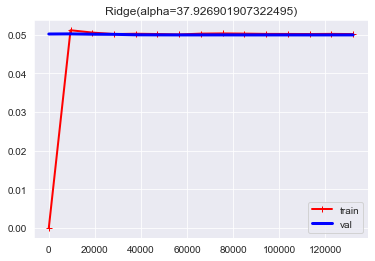

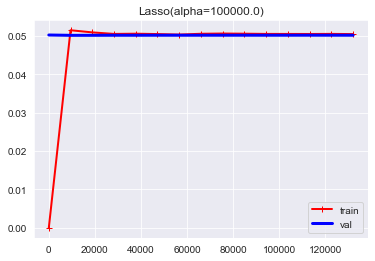

In [95]:
# Learning Curves for Ridge and Lasso
ridge = Ridge(alpha=ridgecv.alpha_)
plt = plot_learning_curves(ridge, X_lin, y_train, X_lin_val, y_val)
plt.show()

lasso = Lasso(alpha=lassocv.alpha_)
plt = plot_learning_curves(lasso, X_lin, y_train, X_lin_val, y_val)
plt.show()

**As expected, even the regularized Linear Models do not perform any better. Thus, we need to consider more complex algorithms which make fewer assumptions to try and understand the relationship between the features and target variable.** 

In [96]:
result = utils.get_eval_metrics([ridge], X_lin_val, y_val)
results['ridge'] = result
result = utils.get_eval_metrics([lasso], X_lin_val, y_val)
results['lasso'] = result

Model: Ridge(alpha=37.926901907322495)
MAE: 0.049982133893831035, RMSE: 0.07598996170631349
Model: Lasso(alpha=100000.0)
MAE: 0.050153838000011726, RMSE: 0.0762536269593192


# Boosting Algorithm

### Missing Data

One of most powerful capabilities of Gradient Boosting machines is their ability to handle missing data. They do not require data imputation and are designed to extract as much information as possible from the rows with missing data. 

# 6 - XGBoost  

In [97]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [98]:
X_prepared = X_train.copy()
X_prepared_val = X_val.copy()

In [99]:
# Feature Dropper Pipeline
xgb_drop = ['parcelid']
feature_dropper = utils.FeatureDropper(features_to_drop=xgb_drop)

# Convert Year Features Pipeline
year_feat_creator = utils.CreateYearFeatures(date_features=date_features)

# Derived Features Creator
derived_feat_creator = utils.CreateDerivedFeatures()

# Date Feature Creator
date_feat_creator = utils.CreateDateFeatures()

# Feature Encoding Pipeline
cat_vars = ['transaction_year', 'transaction_month', 'transaction_day', 'transaction_quarter', 
            'airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 
            'decktypeid', 'fips',  'hashottuborspa', 'heatingorsystemtypeid',  'pooltypeid10', 'pooltypeid2', 
            'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 
            'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 
            'storytypeid',  'typeconstructiontypeid', 'fireplaceflag',  'assessmentyear', 
            'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock', #'N-n_gar_pool_ac','N-PropType','N-HeatInd','N-ACInd'
           ]
feature_encoder = utils.ColumnTransformer([
    ("ohe_cats", OneHotEncoder(handle_unknown='ignore'), cat_vars)
],
    remainder='passthrough'
)

In [100]:
xgb_preprocessor = Pipeline([
    ('feature_dropper', feature_dropper),
    ('date_feat_creator', date_feat_creator),
    ('year_feat_creator', year_feat_creator),
    ('feature_encoder', feature_encoder),
])

data_prep_pipe = xgb_preprocessor.fit(X_prepared)
X_prepared = xgb_preprocessor.transform(X_prepared)
X_prepared_val = xgb_preprocessor.transform(X_prepared_val)

In [101]:
X_xgb = X_prepared.copy()
X_xgb_val = X_prepared_val.copy()

## Tuning Parameters 

The most importnant parameters to tune for Gradient Boosting are: 
- `max_depth`: How deep to build the trees.  This is a very important parameter and performance may change dramatically for different values.  Larger values are more likely to overfit, smaller values more likely to underfit.  

- `learning_rate`, `n_estimators`: These parameters are also very important and interact highly with one another (and with `max_depth`).  Typically, the smaller your "step_size" (learning_rate), the more steps you will need to take to reach maximum performance. However, unlike random forests, if you continue to build trees in boosting, you will start overfitting, and performance (measured on the test set) will get worse.

In [102]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import optuna
from optuna.integration import XGBoostPruningCallback

In [103]:
def objective(trial, X, y):
    param_grid = {
    'max_depth':trial.suggest_int('max_depth', 1, 7), 
    'colsample_bynode': trial.suggest_uniform('colsample_bynode',.3,1),
    'subsample': trial.suggest_uniform('subsample',.3, 1),
    'gamma':trial.suggest_uniform('gamma',.2, 5),
    'tree_method': trial.suggest_categorical('tree_method', ['approx', 'exact']),
    'n_estimators': trial.suggest_categorical("n_estimators", [10000]),
    'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
    'random_state': 42,
    }
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = xgb.XGBRegressor(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="mae",
            verbose=False,
            early_stopping_rounds=25,
            #callbacks=[
            #    XGBoostPruningCallback(trial, "l1")
            #],  
        )
        preds = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_scores)

In [104]:
# Similar to Hyperopt - this code creates an experiment using the objective function and parameter grid above
#study = optuna.create_study(direction="minimize", study_name="XGB Regressor")
#func = lambda trial: objective(trial, X_xgb, y_train.to_numpy())
#study.optimize(func, n_trials=10000)

In [105]:
#print(f"\tBest value (mae): {study.best_value:.5f}")
#print(f"\tBest params:")

#for key, value in study.best_params.items():
    #print(f"\t\t{key}: {value}")

### Best Params Model 

Based on the 1200 ``optuna`` trials, the following hyperparameter values had the best loss: 
```
{'learning_rate': 0.2,
 'n_estimators': 10000,
 'random_state': 42,
 'colsample_bynode': 0.382,
 'gamma': 0.201,
 'max_depth': 5,
 'subsample': 0.95,
 'tree_method': 'exact'}
``` 

In [106]:
%%time
fit_params={
    'early_stopping_rounds': 15, 
    'eval_metric': 'mae',
    'verbose': False,
    'eval_set': [[X_prepared_val, y_val]],
}

best_params = {
    'colsample_bynode': 0.382,   
    'gamma': 0.201,
    'max_depth': 5,   
    'subsample': 0.95, 
    'tree_method': 'exact',
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'random_state': 42,
}
xgb_base = xgb.XGBRegressor(**best_params)
xgb_base.fit(X_xgb, y_train, **fit_params)

CPU times: total: 25min 26s
Wall time: 4min 3s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=0.382, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.201, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [107]:
%%time 
utils.get_eval_metrics([xgb_base], X_xgb_val, y_val)
#utils.get_cross_val_scores([xgb_base], X_prepared, y_train, cv=3, fit_params=fit_params)

Model: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=0.382, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.201, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)
MAE: 0.04973647754453278, RMSE: 0.07558898273267214
CPU times: total: 734 ms
Wall time: 105 ms


0.04973647754453278

In [108]:
result = utils.get_eval_metrics([xgb_base], X_xgb_val, y_val)
results['XGB'] = result

Model: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=0.382, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.201, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)
MAE: 0.04973647754453278, RMSE: 0.07558898273267214


# 7 - CATBoost

In [110]:
import catboost as cb
import optuna 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [111]:
X_prepared = X_train.copy()
X_prepared_val = X_val.copy()

In [112]:
# Feature Dropper Pipeline
var_drop = ['parcelid','censustractandblock','pooltypeid10']
feature_dropper = utils.FeatureDropper(features_to_drop=var_drop)

date_features = {"yearbuilt": "house_age"}
# Convert Date Features Pipeline
year_feat_creator = utils.CreateYearFeatures(date_features=date_features)

# Impute 0
impute_0_vars = ["yardbuildingsqft17", "fireplacecnt", "poolcnt", "garagetotalsqft","garagecarcnt", 
                 "pooltypeid2", "poolsizesum", "decktypeid", "taxdelinquencyflag","pooltypeid7",]

univariate_impute_pipe = utils.ColumnTransformer([
        ("impute_0", SimpleImputer(strategy="constant", fill_value=0), impute_0_vars),
     ],
    remainder='passthrough'
)
# Feature Encoding Pipeline
cat_vars = ['transaction_year','transaction_month', 'transaction_day', 'transaction_quarter', 'airconditioningtypeid', 
            'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 
            'regionidneighborhood', 'regionidzip', 'assessmentyear', 'typeconstructiontypeid', 'architecturalstyletypeid', 
            'buildingclasstypeid', 'pooltypeid2', 'pooltypeid7', 'storytypeid',  'hashottuborspa',# 'pooltypeid10',
            'taxdelinquencyyear',  'taxdelinquencyflag', 'fireplaceflag', 'decktypeid' , 'rawcensustractandblock',
            'propertycountylandusecode', 'propertyzoningdesc',#'N-PropType',
           ]
convert_to_cat = utils.ConvertToType(var_type='str', vars_to_convert=cat_vars)

# Date Feature Creator
date_feat_creator = utils.CreateDateFeatures()

# Derived Features Creator
derived_feat_creator = utils.CreateDerivedFeatures()

#Split census
split_census = utils.SplitCensus()

# Aggregated Feature Creator
group_col = 'regionidcity'
agg_cols = ['lotsizesquarefeet', 'yearbuilt', 'calculatedfinishedsquarefeet',
            'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']
#aggregated_feat_creator = CreateAggregatedFeatures(group_col=group_col, agg_cols=agg_cols)

In [113]:
cb_preprocessor = Pipeline([
    #('derived_feat_creator', derived_feat_creator),
    #('aggregated_feat_creator', aggregated_feat_creator),
    #('split_census',split_census),
    ('date_feat_creator', date_feat_creator),
    ('feature_dropper', feature_dropper),
    ('year_feat_creator', year_feat_creator),
    #('impute0',univariate_impute_pipe),
    ('convert_to_cat', convert_to_cat),
])

data_prep_pipe = cb_preprocessor.fit(X_prepared)
X_prepared = cb_preprocessor.transform(X_prepared)
X_prepared_val = cb_preprocessor.transform(X_prepared_val)

In [114]:
X_cb = X_prepared.copy()
X_cb_val = X_prepared_val.copy()

In [115]:
def objective(trial, X, y):    
    param_grid = {
        # Fixed Params
        "eval_metric": "MAE",
        "n_estimators": 10000,
        "random_state": 42,
    
        # Tuned Params
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.05, 0.3),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    # Conditional Hyper-Parameters
    if param_grid["bootstrap_type"] == "Bayesian":
        param_grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param_grid["bootstrap_type"] == "Bernoulli":
        param_grid["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    cv = KFold(n_splits=3, shuffle=True, random_state=42)

    cv_scores = np.empty(3)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = cb.CatBoostRegressor(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            cat_features=cat_vars,
            early_stopping_rounds=20,
            verbose=False
        )
        preds = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_scores)

In [116]:
# Similar to Hyperopt - this code creates an experiment using the objective function and parameter grid above
#study = optuna.create_study(direction="minimize", study_name="CatBoost Regressor")
#func = lambda trial: objective(trial, X_prepared, y_train.to_numpy())
#study.optimize(func, n_trials=400)

In [117]:
#print(f"\tBest value (mae): {study.best_value:.5f}")
#print(f"\tBest params:")

#for key, value in study.best_params.items():
    #print(f"\t\t{key}: {value}")

In [118]:
best_params = {
    'learning_rate': 0.03,
    'l2_leaf_reg': 3,
    'depth': 6,
    'n_estimators': 900,
    'random_state': 42,
    'eval_metric': "MAE",
    'loss_function': 'MAE',
}

fit_params={
    'cat_features': cat_vars,
    'verbose': False,
}

In [119]:
%%time
cb_base = cb.CatBoostRegressor(**best_params)
cb_base.fit(X_cb, y_train, **fit_params)

CPU times: total: 21min 30s
Wall time: 4min 39s


In [120]:
%%time
utils.get_eval_metrics([cb_base], X_cb_val, y_val)

Model: <catboost.core.CatBoostRegressor object at 0x0000021293A1C910>
MAE: 0.04926265358116735, RMSE: 0.0752986967848598
CPU times: total: 812 ms
Wall time: 269 ms


0.04926265358116735

In [121]:
%%time
#get_cross_val_scores([cb_base], X_cb, y_train, cv=3, fit_params=fit_params)

CPU times: total: 0 ns
Wall time: 0 ns


In [122]:
result = utils.get_eval_metrics([cb_base], X_cb_val, y_val)
results['CB'] = result

Model: <catboost.core.CatBoostRegressor object at 0x0000021293A1C910>
MAE: 0.04926265358116735, RMSE: 0.0752986967848598


# 8 - EXPLAINABILITY

## Model Interpretability 

An important aspect of machine learning model building is to be able to understand and evaluate the models **beyond** simple metrics on their test set performance to be able to trust the model. **This interpretation is extremely cruicial for complex models such as gradient boosting machines which usually perform better than easy to explain models such as Linear Regression, and thus require greater care when being used.** 

Interpretability can include answering questions such as: 

1. Which variables are most important to my model *in general*? 
1. What is the nature of the relationship between the predictors and the target? 
1. Are there significant interaction effects?
1. For a specific prediction, what were the most important reasons leading to that prediction? 

Explore CatBoost that is the best model:


## 1. Global Feature Importance:

Does the model make predictions based on reasonable features? 

```
xgb_base.get_booster().get_score(importance_type='gain')
lgbm_base.feature_importances_
cb_base.get_feature_importance()
```

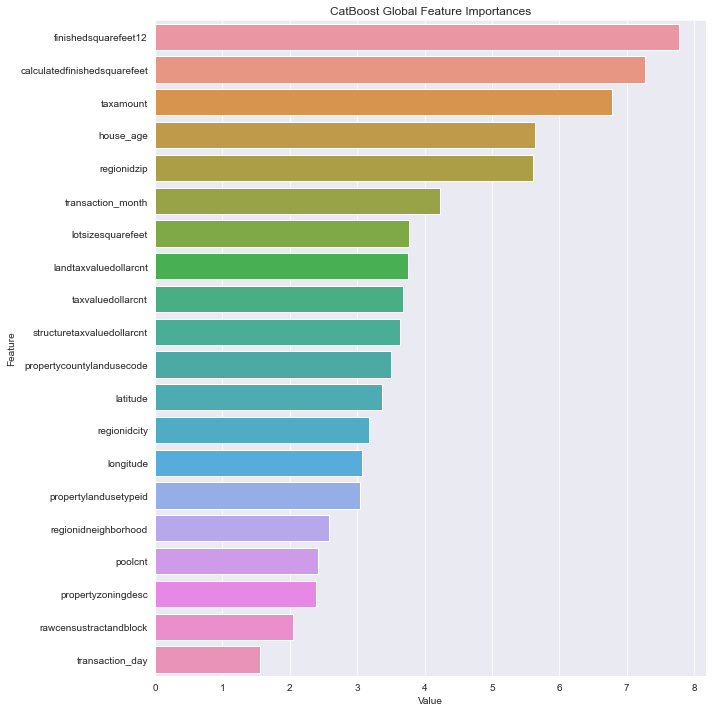

CPU times: total: 266 ms
Wall time: 269 ms


In [124]:
%%time

cb_importances = cb_base.get_feature_importance()
cb_importances = pd.DataFrame(sorted(zip(cb_importances, X_cb.columns)), columns=['Value','Feature'])

cb_importances = cb_importances.sort_values(by='Value', ascending=False)[:20]

plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=cb_importances.sort_values(by="Value", ascending=False))
plt.title('CatBoost Global Feature Importances')
plt.tight_layout()
plt.show()

## 2. Permutation importance

In [125]:
%%time

from sklearn.inspection import permutation_importance
result = permutation_importance(cb_base, X_cb_val, y_val, n_repeats=10,random_state=42)

CPU times: total: 7min 50s
Wall time: 2min 27s


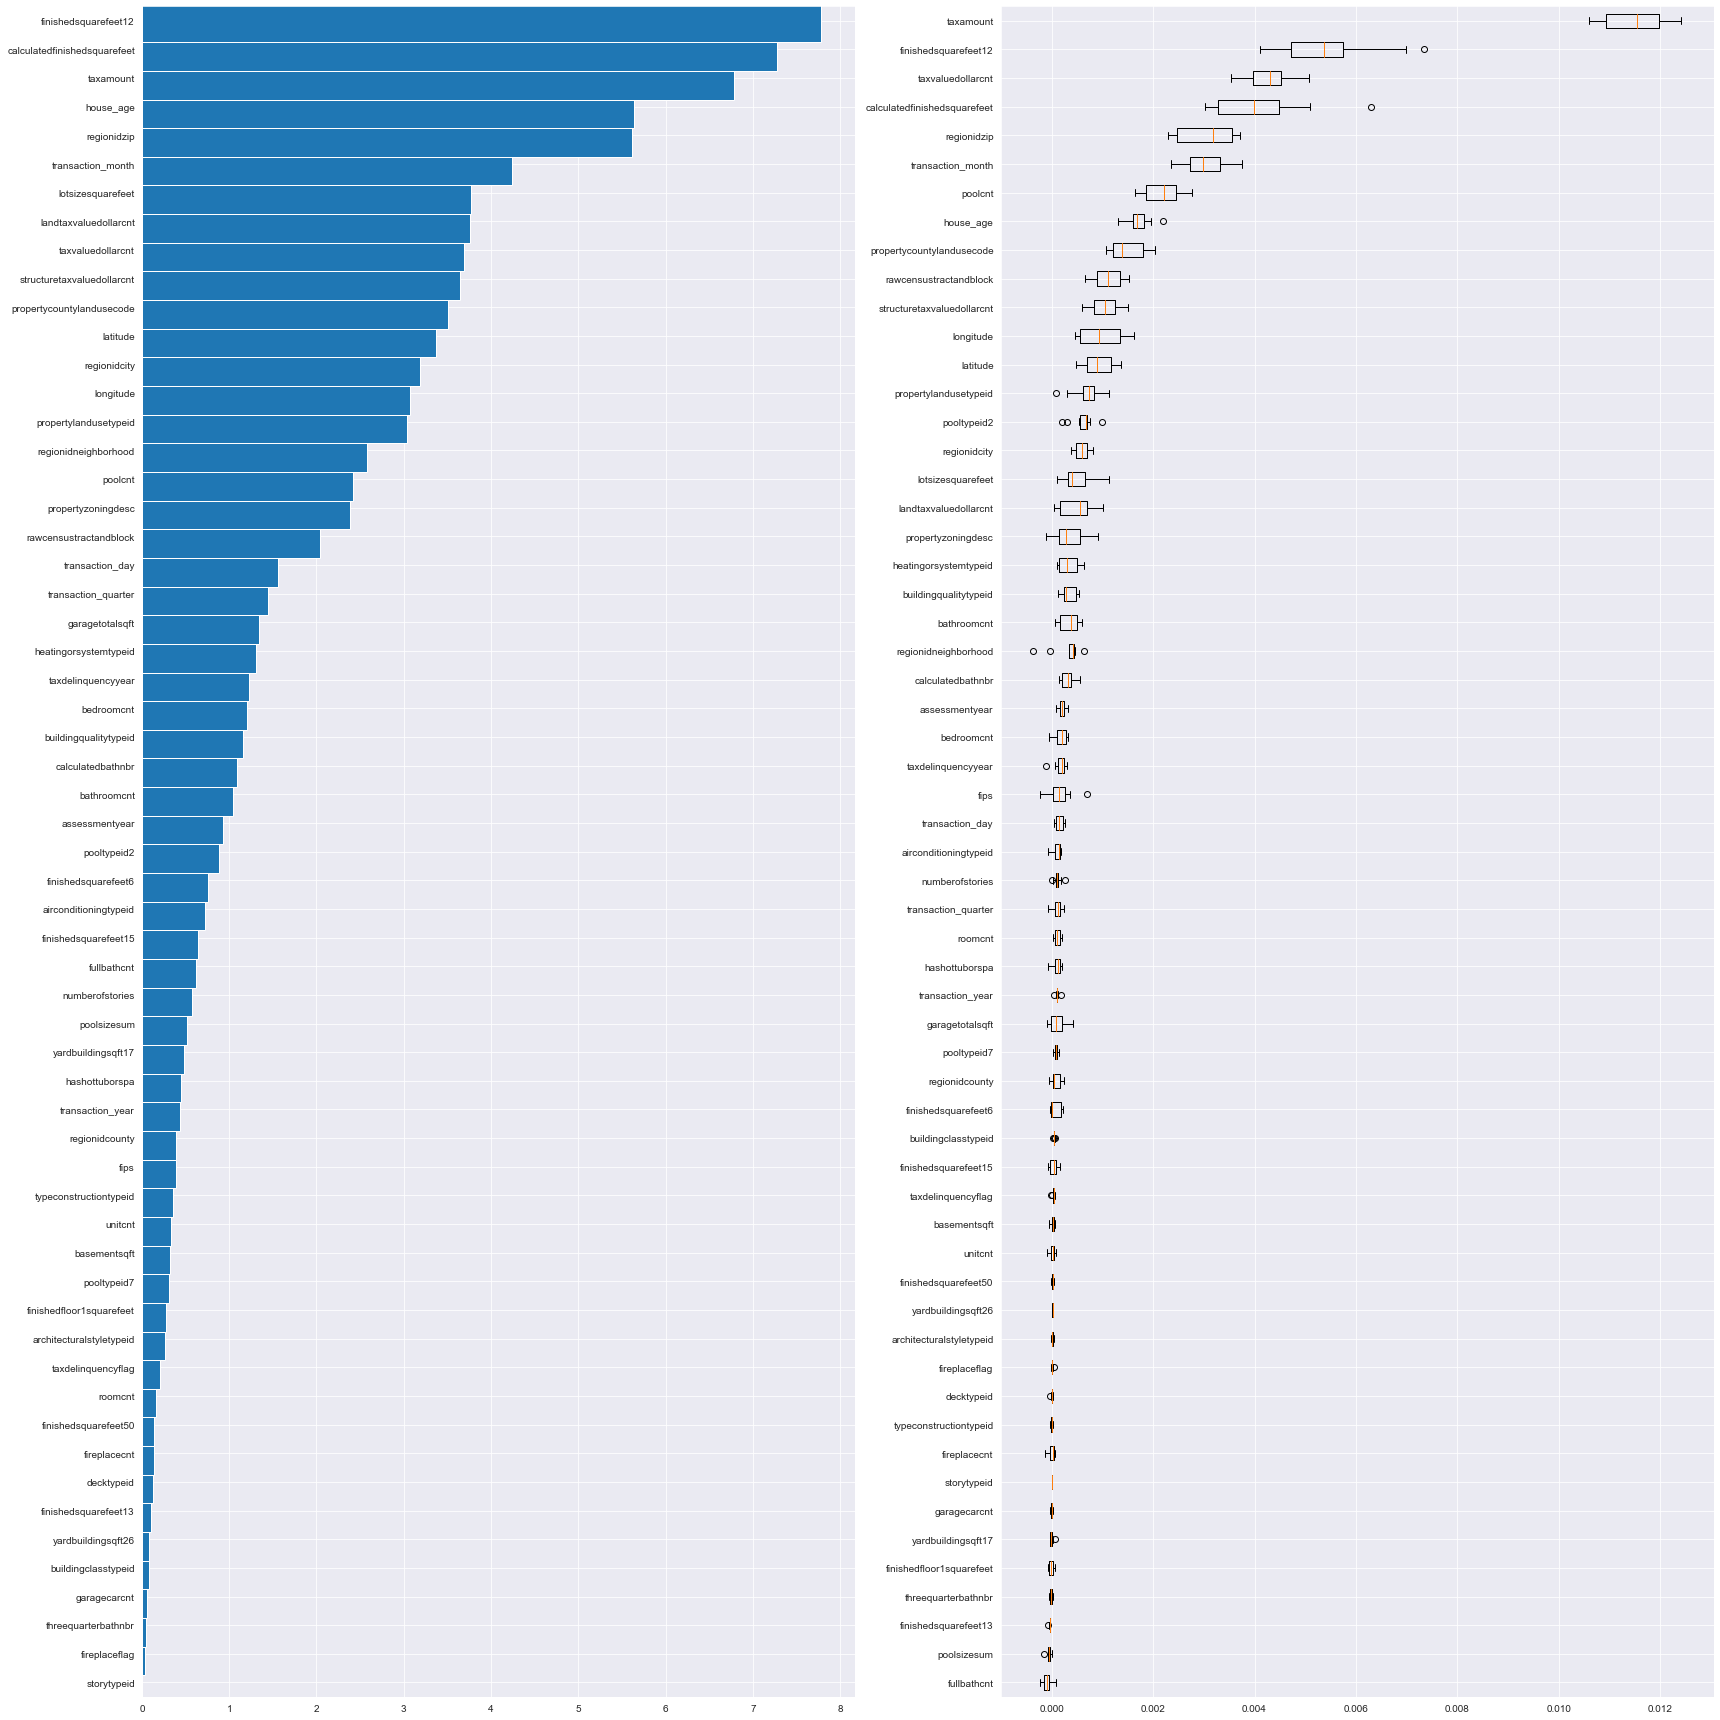

CPU times: total: 1.59 s
Wall time: 1.61 s


In [126]:
%%time
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(cb_base.feature_importances_)
tree_indices = np.arange(0, len(cb_base.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 24))
ax1.barh(tree_indices, cb_base.feature_importances_[tree_importance_sorted_idx], height=1.5)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X_cb_val.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(cb_base.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_cb_val.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

The permutation importance plot shows that permuting a feature has impact on MAE by at most 0.07.
The permutation importance is calculated on the training set to show how much the model relies on each feature during training.

In [127]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

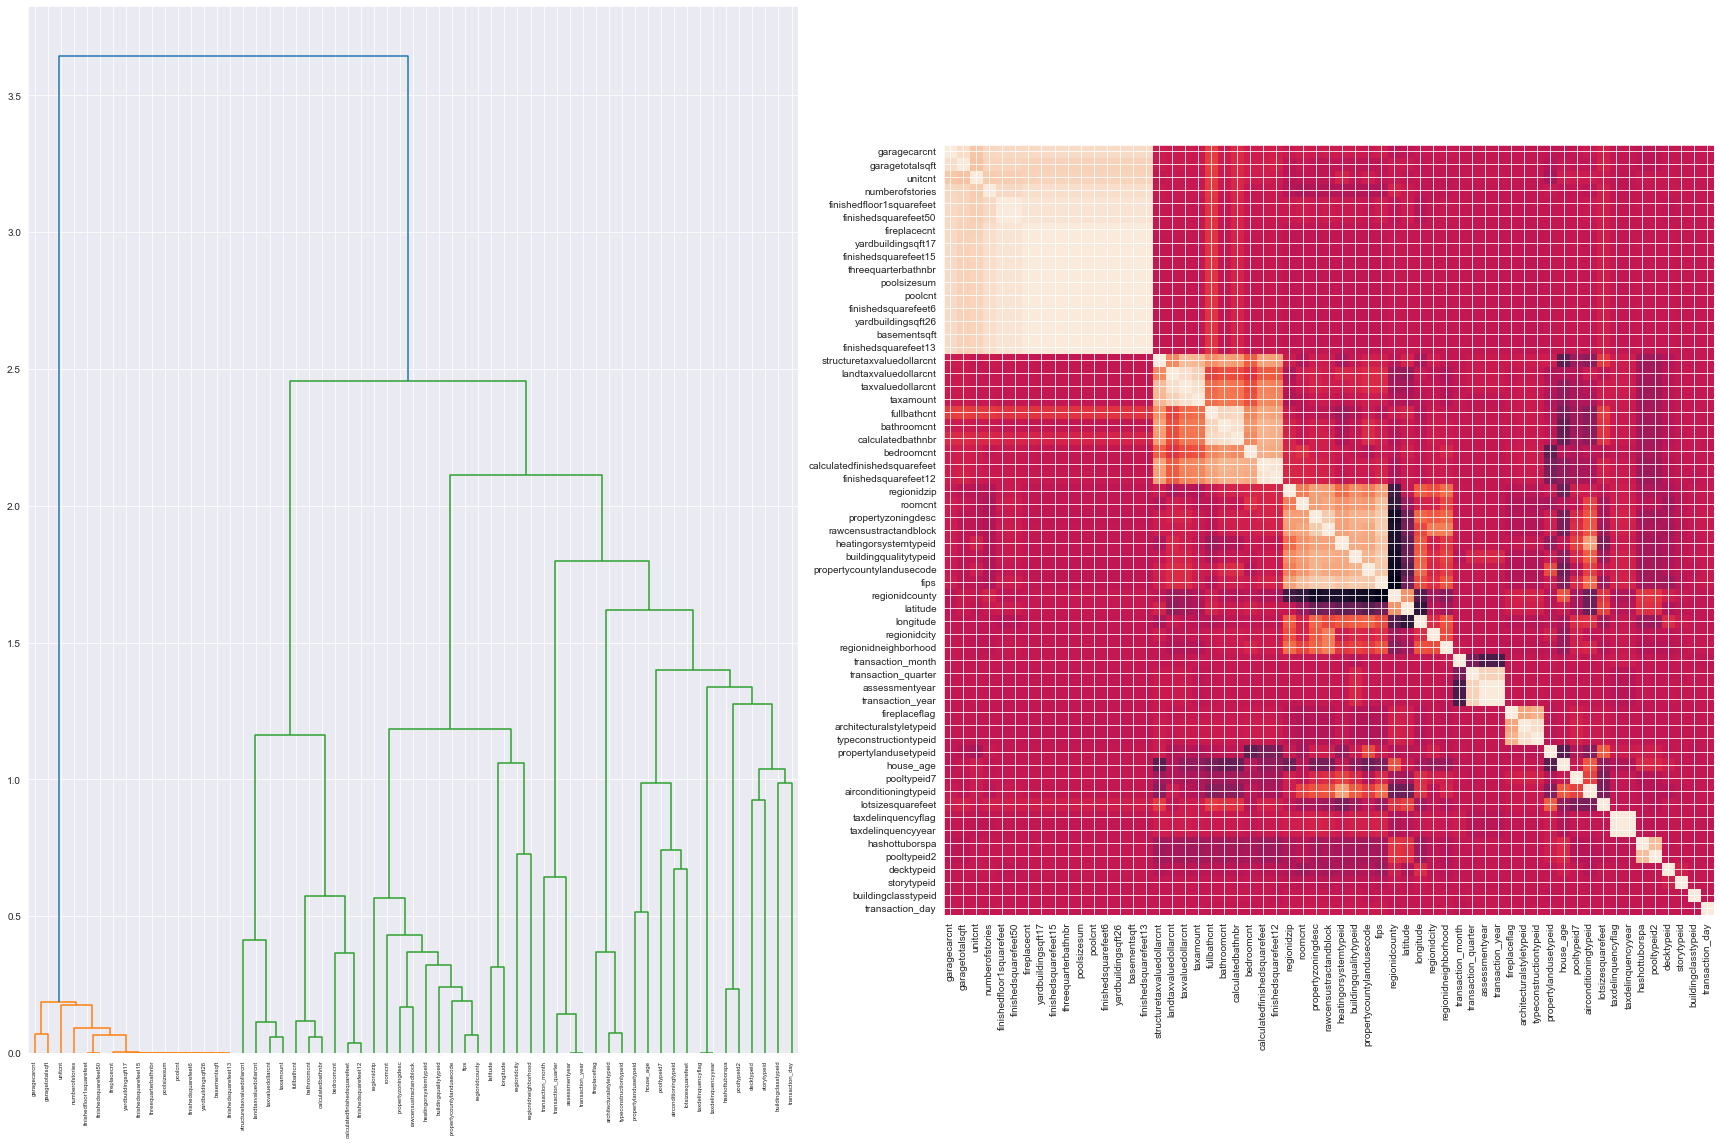

CPU times: total: 9min 15s
Wall time: 9min 18s


In [128]:
%%time

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16))
corr = spearmanr(X_cb_val).correlation

corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_cb_val.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [129]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.0005, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]


In [130]:
X_train_sel = X_cb.iloc[:,selected_features]
X_val_sel = X_cb_val.iloc[:,selected_features]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 38,
 39,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 64,
 66,
 68,
 69,
 70,
 71,
 75,
 76,
 78,
 79,
 80,
 83,
 84,
 85,
 86,
 87,
 89,
 90,
 91,
 92]

In [131]:
len(selected_features)

48

In [132]:
%%time
backup=[]
for c in X_train_sel.columns:
    if c in cat_vars:
        backup.append(c)
best_params = {
    'learning_rate': 0.03,
    'l2_leaf_reg': 3,
    'depth': 6,
    'n_estimators': 900,
    'random_state': 42,
    'eval_metric': "MAE",
    'loss_function': 'MAE',
}
fit_params={
    'cat_features': backup,
    'verbose': False,
}
cb_base_sel = cb.CatBoostRegressor(**best_params)
cb_base_sel.fit(X_train_sel, y_train, **fit_params)

CPU times: total: 20min 22s
Wall time: 4min 19s


In [133]:
get_eval_metrics([cb_base_sel],X_val_sel,y_val)

Model: <catboost.core.CatBoostRegressor object at 0x00000212941AFB80>
MAE: 0.04924847156355185, RMSE: 0.07529218710967432


0.04924847156355185

## 3. Local Feature Importance 

Can we trust the model's prediction for one specific data point? 

Local importance tries to help explain how different feature might be interaction and how the model makes a **specific** prediction. We will be highlighting two different tools to help with this: 

1. **ICE (Individual Conditional Expectation) Plots**: Excellent tool to understand "what the model is thinking". 
2. **SHAP**: Motivated by "Shapley Value" in Game Theory, this aims to explain why a particular instance is "different" from average and which features contribute to the *specific* prediction. 

## 4. ICE Plots 
 
Individual Conditional Expectation (ICE) plots display one line per instance that shows how the instance’s prediction changes when a feature changes. The values for a line can be computed by keeping all other features the same, creating variants of this instance by replacing the feature’s value with values from a grid and making predictions with the black box model for these newly created instances. The result is a set of points for an instance with the feature value from the grid and the respective predictions.

How do ICE plots work?
- Take an actual data point and see what the model predicts.
- Pick a variable and change the value of that variable (over some range of values).
- Plot the model prediction as a function of the "altered" value
- Do this for multiple points, and plot on the same graph
- Do this for all variables of interest

In [134]:
import ml_insights as mli

In [135]:
range_pts = mli.get_range_dict(X_cb)
test_pts = X_cb_val.sample(5, random_state=42)
imp_num_feat = [
    'calculatedfinishedsquarefeet', 'house_age',
    'taxamount', 'structuretaxvaluedollarcnt', 'latitude' 
]

The ranges of values used for x-axis need to be updated to remove outliers to better interpret the ICE-plot.

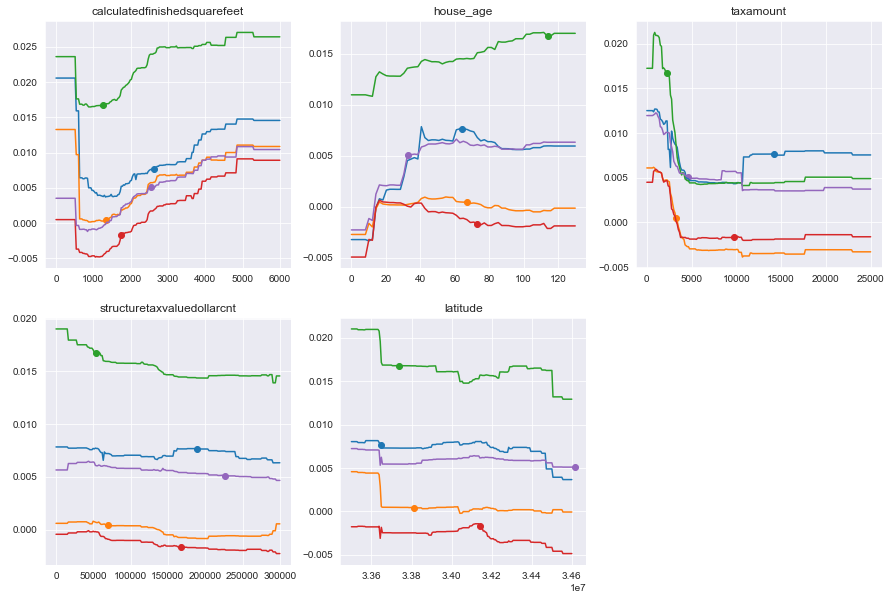

In [136]:
# Updating the ranges of features on x-axis for better interpretation 
range_pts['calculatedfinishedsquarefeet'] = np.linspace(0, 6000, 200)
range_pts['house_age'] = np.linspace(0, 130, 65)
range_pts['taxamount'] = np.linspace(0, 25000, 200)
range_pts['structuretaxvaluedollarcnt'] = np.linspace(0, 300000, 200)
range_pts['latitude'] = np.linspace(3.35e+07, 3.46e+07, 200)

mli.ice_plot(cb_base, test_pts, imp_num_feat, range_pts=range_pts, pred_fn='predict', figsize=(15,10))

### Interpreting ICE plots

Things to look for: 
- When the line is flat, that means the variable is unimportant in that range (for that particular data point)
- When the line is steep, that means the variable has a strong effect on the target in that range.
- If the line is very wiggly, this often betrays some degree of "overfitting" in the model.  Interestingly, this is often *not* reflected in the test set metrics.  However, it is reflective of the "coherence" of the model.  It also may reflect a paucity of training data in that region
- If all the lines show the same basic effect, this suggests that there is little interaction.
- If some lines have very different trajectories, this indicates a high degree of interactivity.


ICE-plots tell us what the *model* thinks.  To the extent that the model is reflective of the "real world" that generated the data, it may be useful in understanding the real world.  However, it may also be demonstrating places where the model is wrong, has little data, or is displaying artifacts of the way it was trained.  This is where our "human" thinking can be combined with the model to try and understand the world better.

## 5. SHAP: Explaining Individual Predictions

Goal of SHAP values is to: 
- Explain why a particular instance is "different" from average.
- Which features / concepts contributed most to its "distinctiveness"?
- Can we attribute the "distance from average" of a particular case to the individual features?

Reference: https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

In [137]:
# !pip install shap #if you don't have it installed
import shap
shap.initjs()

In [138]:
%%time
explainer = shap.TreeExplainer(cb_base)
shap_values = explainer(X_cb)

# The SHAP expected value is the median of the target variable 
explainer.expected_value, np.mean(y_train)

CPU times: total: 54.5 s
Wall time: 18.4 s


(0.006087875933386937, 0.007901119285659876)

### SHAP for Global Interpretability 

Thanks to its versatility, SHAP values can also be used to get a sense of how "globally" important a feature is by aggregating the (absolute value of) the local feature values. These numbers can be thought of as the "average absolute impact" that a variable has on the prediction.

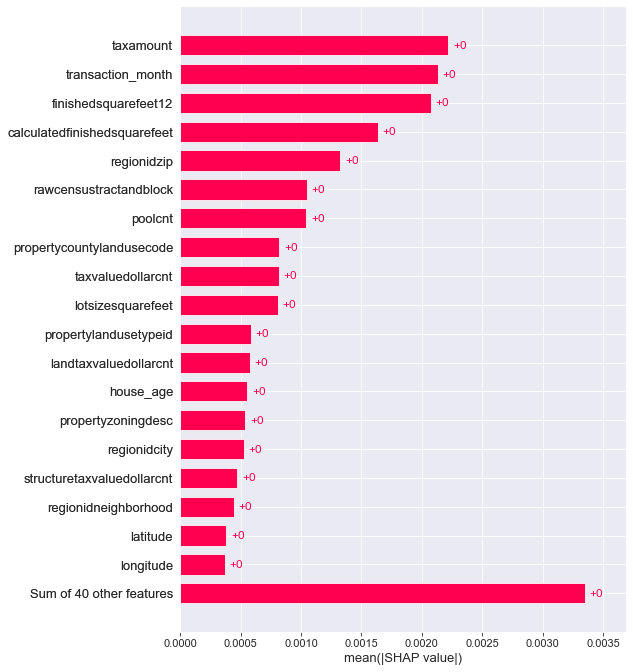

In [139]:
shap.plots.bar(shap_values, max_display=20)

The bar plot of the absolute SHAP values paints an interesting and *slightly* different picture than the ``feature_importances_`` function earlier which said ``house_age`` was one of the most important feature. However, according to the SHAP bar plot above, there are many other variables that contribute greater to the final predicted value on average.

Furthermore, ``rawcensustractandblock`` and ``poolcnt`` are within top 7 contributors according to SHAP values compared to not even being in top 15 according to ``feature_importance_``. This can be a clue to further dig into these variables' impact and analyze whether their affects are postively or negatively affecting the model.

### Waterfall Plots

SHAP explains how individual predictions are arrived at in terms of the contributions from each of the model's input variables. This is a highly intuitive approach that produces simple but informative outputs. 

Waterfall plots the most complete display of a single prediction. The waterfall structure emphasizes the additive nature of positive and negative contributors, and how they build on the *base value* to yield the model's prediction, $f(x)$

Target feature values are extremely tiny (mean of 0.006), so the contributions shown in most charts below will be zero due to rounding. However, the positive and negative contributions can still be seen based on colors in below charts.


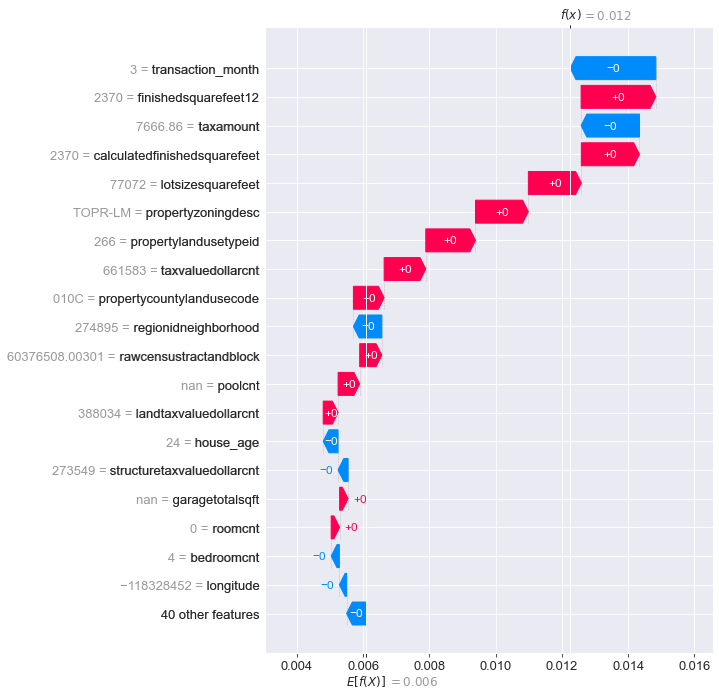

In [140]:
i_med = np.argsort(y_train)[len(y_train)//2]    
i_80 = np.argsort(y_train)[int(len(y_train)*0.80)]  
i_20 = np.argsort(y_train)[int(len(y_train)*0.20)]  

shap.plots.waterfall(shap_values[i_20], max_display=20)

Waterfall plot display that ``finishedsquarefeet12`` and ``transaction_month`` are very important in this specific prediction.

### Force Plots 

Force plots are equivalent representations as Waterfall plots that display the key information is a more condensed format. 

In [141]:
# Force plot for 20th percentile y_train value
shap.plots.force(shap_values[i_20])

In [142]:
# Force plot for 80th percentile y_train value
shap.plots.force(shap_values[i_80])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset:


In [143]:
shap_values_expl = explainer.shap_values(X_cb)

In [144]:
n_samples = 10
shap.force_plot(explainer.expected_value, shap_values_expl[0:n_samples], X_cb[0:n_samples])

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature’s responsibility for a change in the model output, the plot below represents the change in predicted Zestimate error as 'taxamount' changes. Vertical dispersion at a single value of 'taxamount' represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by 'taxvaluedollarcnt' highlights that 'taxamount' has less impact on home price for areas close to radial highways.

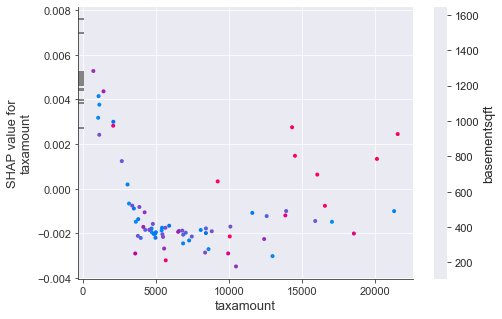

In [145]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("taxamount", shap_values_expl, X_cb,interaction_index="basementsqft") 

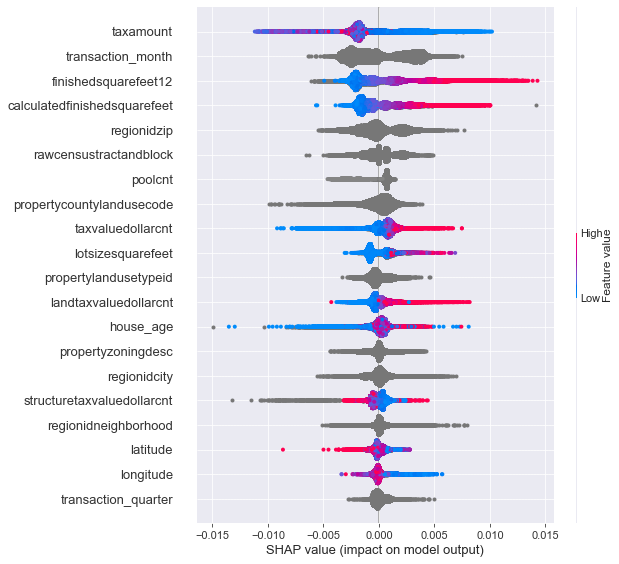

In [146]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_cb)

In the SHAP plot, the features are ranked based on their average absolute SHAP and the colors represent the feature value (red high, blue low and grey NaN). The higher the SHAP value, the larger the predictor’s attribution. In other words, the SHAP values represent a predictor’s responsibility for a change in the model output. This reveals for example that larger 'taxamount' are associated with increasing of decreasing of error and viceversa.

# FUTURE WORK:
- MetaLearner
- More investigation about explainability